## Methods
1 - Feed Random Noise and reconstruct the data

2 - Start with clean data, keep adding on noise slowly

3 - Reduce dimension - Done

In [1]:
import torch.nn.functional as F
import torch
from torch_geometric.nn import Sequential, GCNConv

import numpy as np
from pgmpy.metrics import correlation_score
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from scipy.stats import chi2_contingency
import pandas as pd

import bnlearn as bn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# from torch_geometric.nn.models import GAT
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.explain import AttentionExplainer, ModelConfig, ExplainerConfig, Explainer, GNNExplainer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def undirected_SHD(g1, g2):
    g1 = np.tril(((g1 + g1.T) > 0).astype(int))
    g2 = np.tril(((g2 + g2.T) > 0).astype(int))
    return np.sum(np.abs(g1-g2))

In [6]:
def comb_SHD(g1, g2):
    return np.sum(np.abs(g1 - g2)), undirected_SHD(g1,g2)

In [122]:
num_samples = 10000
file_name = "asia"
model_asia = bn.import_DAG("BIFs/" + file_name + ".bif")
df_asia = bn.sampling(model_asia, n=num_samples)
# df_asia = df_asia.drop(file_name, axis=1)
nodes_orig = list(model_asia['adjmat'].columns)
asia_dag = DAG(model_asia['adjmat'])

[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.


In [123]:
df_asia

,asia,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,0,1,0,1,1,0
1,1,1,1,1,0,1,1,0
2,1,1,0,1,0,1,1,0
3,1,1,1,1,1,1,1,1
4,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...
9995,1,1,0,1,1,1,1,1
9996,1,1,0,1,1,1,1,1
9997,1,1,1,0,1,0,0,1
9998,1,1,1,1,0,1,1,1


In [124]:
df_asia.T.to_numpy().shape

(8, 10000)

[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


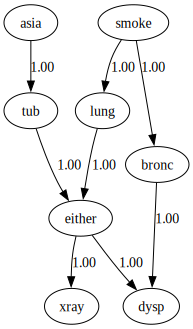

In [125]:
bn.plot_graphviz(model_asia)

In [126]:
df_asia.to_numpy()

array([[1, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [127]:
edge_index = []
for i in range(len(df_asia.columns)):
    for j in range(i+1, len(df_asia.columns)):
        edge_index.append([i,j])
        edge_index.append([j,i])
edge_index = torch.tensor(np.array(edge_index))

In [936]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels* heads, data.num_nodes, heads=1, dropout=0)
        self.conv3 = GATConv(data.num_nodes*self.conv2.heads, out_channels, heads, concat=False, dropout=0)
        self.att_wt = None

    def forward(self, x, edge_index, return_att = False):
        x = F.dropout(x, p=0.3, training=self.training)
        if return_att:
            x, att_wt = self.conv1.forward(x, edge_index, return_attention_weights=True)
            self.att_wt = att_wt
        else:
            x= self.conv1.forward(x, edge_index)
            
        x = F.relu(x)
        # print(x.shape)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        # print(x.shape)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.softmax(x, dim=1)
        # print(x.shape)
        return x

In [1095]:
data = Data()

In [1096]:
data.x = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples))
# data.x = torch.rand((len(df_asia.columns), 100))
data.edge_index = edge_index.t().contiguous()

In [1097]:
data

Data(x=[8, 10000], edge_index=[2, 56])

In [1184]:
model = GAT(data.x.shape[1], 20, num_samples, heads=data.num_nodes)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
loss_fn = torch.nn.CrossEntropyLoss()

In [1185]:
true_vals = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples))

In [1186]:
model

GAT(
  (conv1): GATConv(10000, 20, heads=8)
  (conv2): GATConv(160, 8, heads=1)
  (conv3): GATConv(8, 10000, heads=8)
)

In [1187]:
data.num_nodes

8

In [1188]:
target = torch.tensor(model_asia['adjmat'].astype(int).to_numpy().astype("float32"))

In [1189]:
model.train()
losses = []
for i in tqdm(range(1000)):
    optim.zero_grad()
    out = model(data.x, data.edge_index)
    if i % 50 == 0:
        data.x = torch.tensor(df_asia.T.to_numpy().astype("float32").reshape(-1, num_samples)) + torch.randn((data.num_nodes, num_samples)) * (i / 1000) 
    
    loss1 = loss_fn(true_vals, out)
    loss1.backward()
    
    optim.step()
    scheduler.step()
    losses.append(loss1.item())


00%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.22it/s]

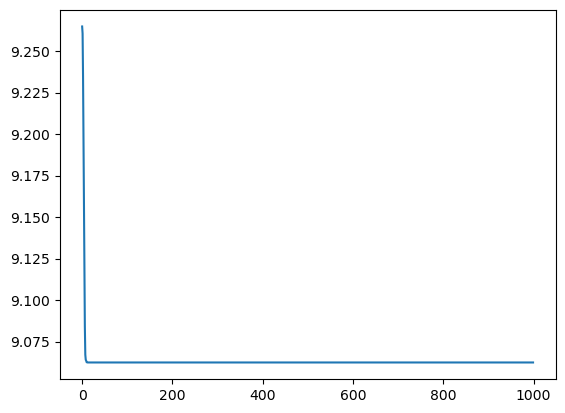

In [1191]:
plt.plot(losses)

In [1192]:
min(losses)

9.062374114990234

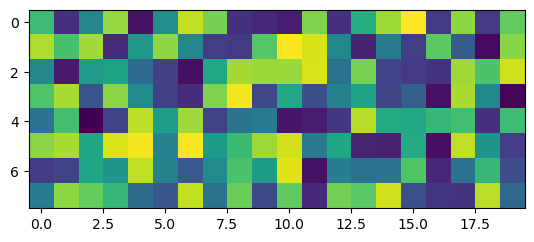

In [1193]:
plt.imshow(model.conv1.att_dst.detach().numpy()[0])

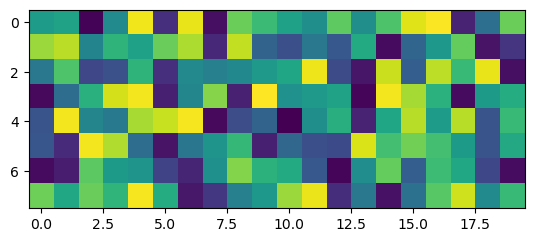

In [1194]:
plt.imshow(model.conv1.att_src.detach().numpy()[0])

In [1217]:
explainer = Explainer(
    model = model, 
    explanation_type="model",
    algorithm=AttentionExplainer(reduce="mean"),
    node_mask_type=None,
    edge_mask_type='object',
    model_config = ModelConfig(
        mode='binary_classification',
        task_level='edge',
        return_type='raw'
    )
)

In [1218]:
explanation = explainer(
    data.x, data.edge_index
)

In [1219]:
explanation.available_explanations

['edge_mask']

In [1220]:
explanation['edge_mask']

tensor([0.2579, 0.2398, 0.2709, 0.0819, 0.2579, 0.0870, 0.2709, 0.0819, 0.2579,
        0.0852, 0.2579, 0.0844, 0.2709, 0.0819, 0.2288, 0.0819, 0.2398, 0.0870,
        0.2288, 0.0819, 0.2398, 0.0852, 0.2398, 0.0844, 0.2288, 0.0819, 0.0819,
        0.0859, 0.0819, 0.0819, 0.0819, 0.0843, 0.0819, 0.0842, 0.0819, 0.0819,
        0.0859, 0.0819, 0.0870, 0.0852, 0.0870, 0.0844, 0.0859, 0.0819, 0.0819,
        0.0843, 0.0819, 0.0842, 0.0819, 0.0819, 0.0852, 0.0844, 0.0843, 0.0819,
        0.0842, 0.0819])

In [1221]:
explanation['edge_mask'].shape

torch.Size([56])

In [1222]:
data.edge_index.shape

torch.Size([2, 56])

In [1223]:
temp_adj = np.zeros((data.num_nodes, data.num_nodes))
for i in range(len(data.edge_index[0])):
    temp_adj[data.edge_index[0][i]][data.edge_index[1][i]] = explanation['edge_mask'][i].item()

In [1224]:
temp_adj

array([[0.        , 0.25786406, 0.27094451, 0.25786412, 0.27094451,
        0.25786409, 0.25786406, 0.27094439],
       [0.23977597, 0.        , 0.22883248, 0.23977591, 0.22883256,
        0.23977585, 0.2397759 , 0.22883244],
       [0.08194313, 0.08194313, 0.        , 0.08194313, 0.08194318,
        0.08194309, 0.08194309, 0.08194338],
       [0.08696122, 0.08696122, 0.08592244, 0.        , 0.08592248,
        0.0869615 , 0.0869615 , 0.08592236],
       [0.08194329, 0.08194329, 0.08194315, 0.08194329, 0.        ,
        0.08194325, 0.08194325, 0.08194339],
       [0.08517987, 0.08517987, 0.08428951, 0.08517987, 0.08428955,
        0.        , 0.08517983, 0.08428943],
       [0.08438952, 0.08438952, 0.08418164, 0.08438952, 0.08418169,
        0.08438948, 0.        , 0.08418157],
       [0.08194298, 0.08194298, 0.08194315, 0.08194298, 0.08194288,
        0.08194294, 0.08194294, 0.        ]])

In [1225]:
upper_t = np.triu(temp_adj)
lower_t = np.tril(temp_adj)

In [1226]:
upper_t

array([[0.        , 0.25786406, 0.27094451, 0.25786412, 0.27094451,
        0.25786409, 0.25786406, 0.27094439],
       [0.        , 0.        , 0.22883248, 0.23977591, 0.22883256,
        0.23977585, 0.2397759 , 0.22883244],
       [0.        , 0.        , 0.        , 0.08194313, 0.08194318,
        0.08194309, 0.08194309, 0.08194338],
       [0.        , 0.        , 0.        , 0.        , 0.08592248,
        0.0869615 , 0.0869615 , 0.08592236],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.08194325, 0.08194325, 0.08194339],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08517983, 0.08428943],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.08418157],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [1253]:
lower_t

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.23977597, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.08194313, 0.08194313, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.08696122, 0.08696122, 0.08592244, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.08194329, 0.08194329, 0.08194315, 0.08194329, 0.        ,
        0.        , 0.        , 0.        ],
       [0.08517987, 0.08517987, 0.08428951, 0.08517987, 0.08428955,
        0.        , 0.        , 0.        ],
       [0.08438952, 0.08438952, 0.08418164, 0.08438952, 0.08418169,
        0.08438948, 0.        , 0.        ],
       [0.08194298, 0.08194298, 0.08194315, 0.08194298, 0.08194288,
        0.08194294, 0.08194294, 0.        ]])

In [1266]:
thresh = np.max(np.abs(adj_1)) - 0.5 * np.std(np.abs(adj_1))
adj_1 = lower_t - upper_t.T
new_adj = np.zeros((data.num_nodes, data.num_nodes))

In [1267]:
for i in range(len(adj_1)):
    for j in range(0, i):
        if i==j:
            continue
        if adj_1[i][j] > thresh:
            new_adj[j][i] = 1
        elif np.abs(adj_1[i][j]) > thresh:
            new_adj[i][j] = 1

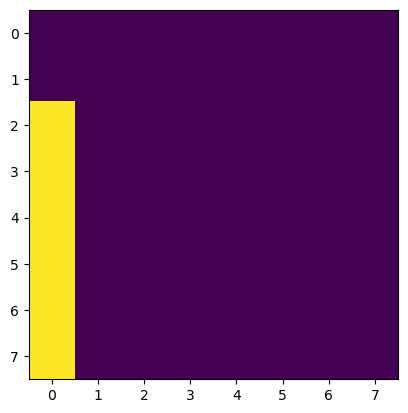

In [1268]:
plt.imshow(new_adj)

In [1269]:
g = nx.DiGraph(new_adj, nodes=df_asia.columns)

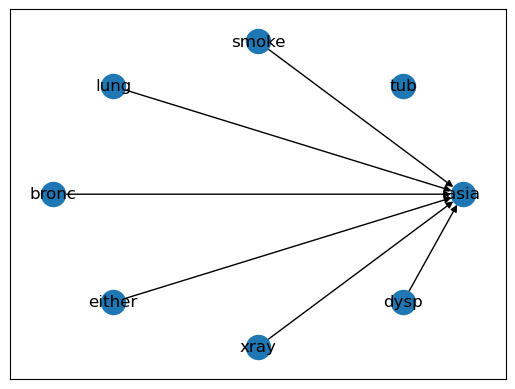

In [1270]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:df_asia.columns[i] for i in range(len(g.nodes))
})

In [1271]:
comb_SHD(new_adj, model_asia['adjmat'].astype(int).to_numpy())

(14.0, 14)

In [1272]:
max(explanation['edge_mask'])

tensor(0.2709)

In [1273]:
torch.std(explanation['edge_mask'])

tensor(0.0728)

In [1274]:
torch.mean(explanation['edge_mask'])

tensor(0.1250)

In [1275]:
att_thresh = (explanation['edge_mask'] > torch.mean(explanation['edge_mask']) + 1 * torch.std(explanation['edge_mask'])).detach().numpy().astype(int)
# att_thresh = explanation['edge_mask'] == max(explanation['edge_mask'])

In [1276]:
temp_adj = np.zeros((adj_mat_size, adj_mat_size), dtype=int)
for i in range(len(att_thresh)):
    if att_thresh[i] == 1:
        print(edge_index[i].detach().numpy())
        idx = edge_index[i].detach().numpy()
        temp_adj[idx[1]][idx[0]] = 1

[0 1]
[1 0]
[0 2]
[0 3]
[0 4]
[0 5]
[0 6]
[0 7]
[1 2]
[1 3]
[1 4]
[1 5]
[1 6]
[1 7]


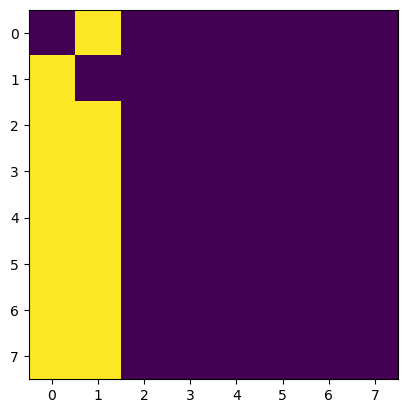

In [1277]:
plt.imshow(temp_adj)

In [1278]:
comb_SHD(temp_adj, model_asia['adjmat'].astype(int).to_numpy())

(20, 17)

In [1279]:
g = nx.DiGraph(temp_adj, nodes=df_asia.columns)

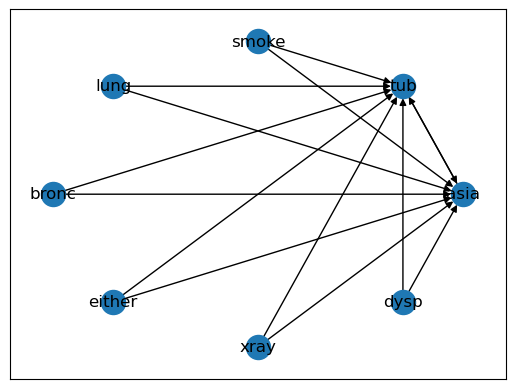

In [1280]:
pos = nx.circular_layout(g)
nx.draw_networkx(g, pos, labels = {
    i:df_asia.columns[i] for i in range(len(g.nodes))
})

In [1281]:
explanation.visualize_graph(node_labels=df_asia.columns)

In [1282]:
max(losses)

9.26478385925293

In [1179]:
min(losses)

0.7973874807357788

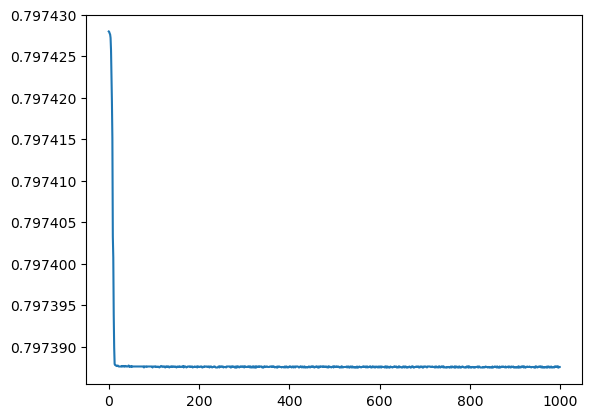

In [1180]:
plt.plot(losses)